In [134]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

### Load dataset  and look at basic info

In [135]:
dataframe = pd.read_csv('Testovoe_zadanie_dataframe.csv',sep=';',encoding='cp1251')
print(dataframe.head(10),'\n')
total_rows = dataframe.shape[0]
not_null_rows = dataframe['Что-то'].notnull().sum()

print('Total rows: ',total_rows)
print('Not null rows: ',not_null_rows)
print('Null percentage',1 - not_null_rows/total_rows)

data = dataframe['Что-то']
timestamp = dataframe['Time']

print('data range: from', timestamp[0], ' to ',timestamp.iloc[-1])
data.describe()

               Time  Что-то
0  27.07.2022 15:15   718.0
1  27.07.2022 15:30   665.0
2  27.07.2022 15:45   637.0
3  27.07.2022 16:00   661.0
4  27.07.2022 16:15   668.0
5  27.07.2022 16:30   687.0
6  27.07.2022 16:45   692.0
7  27.07.2022 17:00   640.0
8  27.07.2022 17:15   680.0
9  27.07.2022 17:30   678.0 

Total rows:  2881
Not null rows:  2718
Null percentage 0.05657757723012846
data range: from 27.07.2022 15:15  to  26.08.2022 15:15


count    2718.000000
mean      368.701619
std       295.226746
min         0.000000
25%        61.000000
50%       348.000000
75%       668.000000
max       982.000000
Name: Что-то, dtype: float64

* 5 percent of null values - not so much

### Fill NA values + convert to datetime

In [136]:
#pad vs backfill
dataframe.fillna(method="pad",inplace=True)

#Before!
f = plt.figure()
f.set_size_inches(32,8)
plt.plot(timestamp,data) 

#After!
dataframe.index = pd.to_datetime(dataframe['Time'], errors='coerce', format='%d.%m.%Y %H:%M')
dataframe.drop(columns=['Time'],inplace=True)
assert dataframe.shape == 2881, 'Error, shape of timeseries changed'

### Plotting

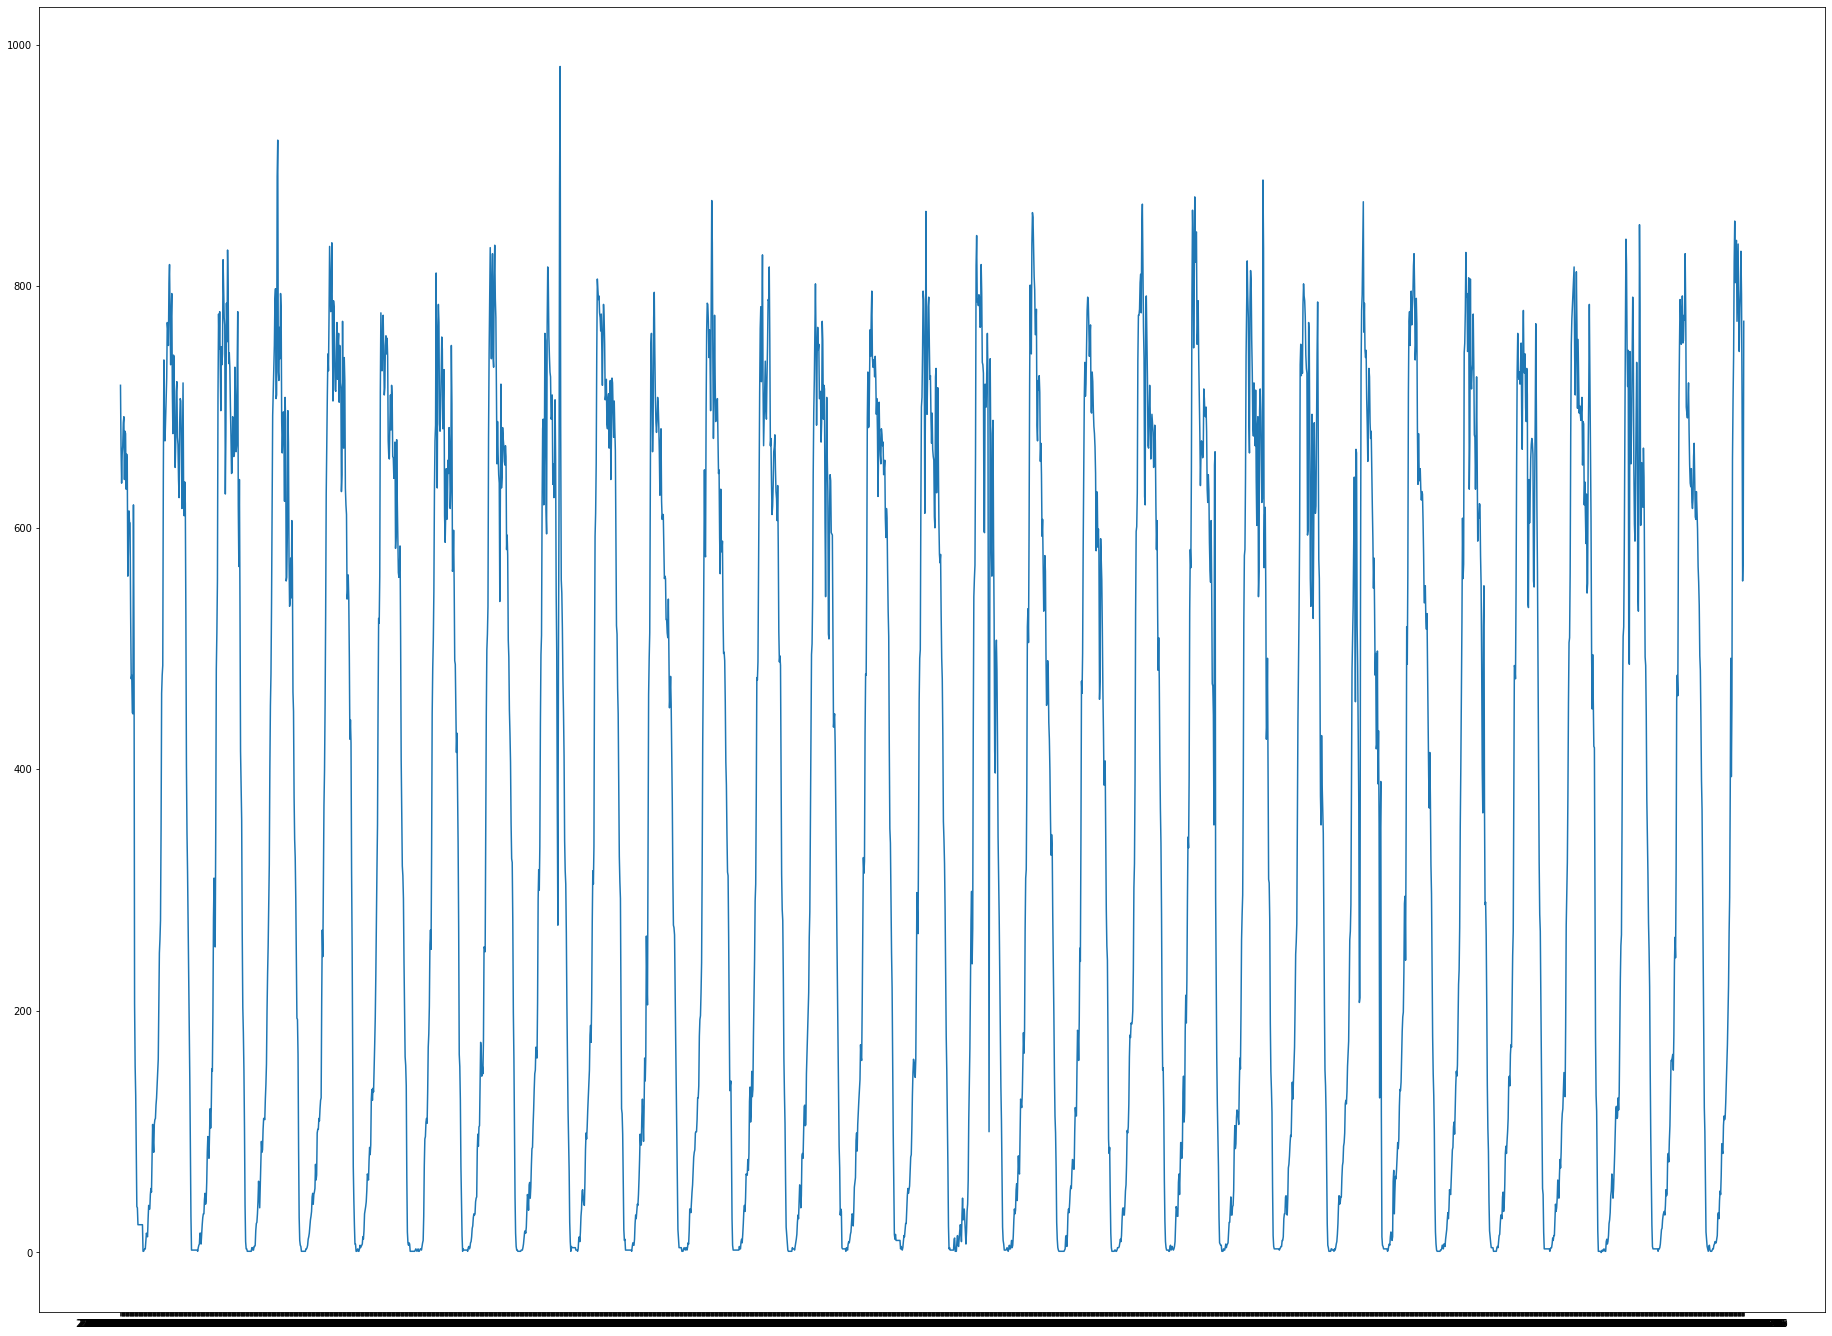

In [137]:
f = plt.figure()
f.set_size_inches(32,8)
plt.plot(timestamp,data) # x asis change

* looks like sine/cosine function with some noise

#### Time series decompasition   

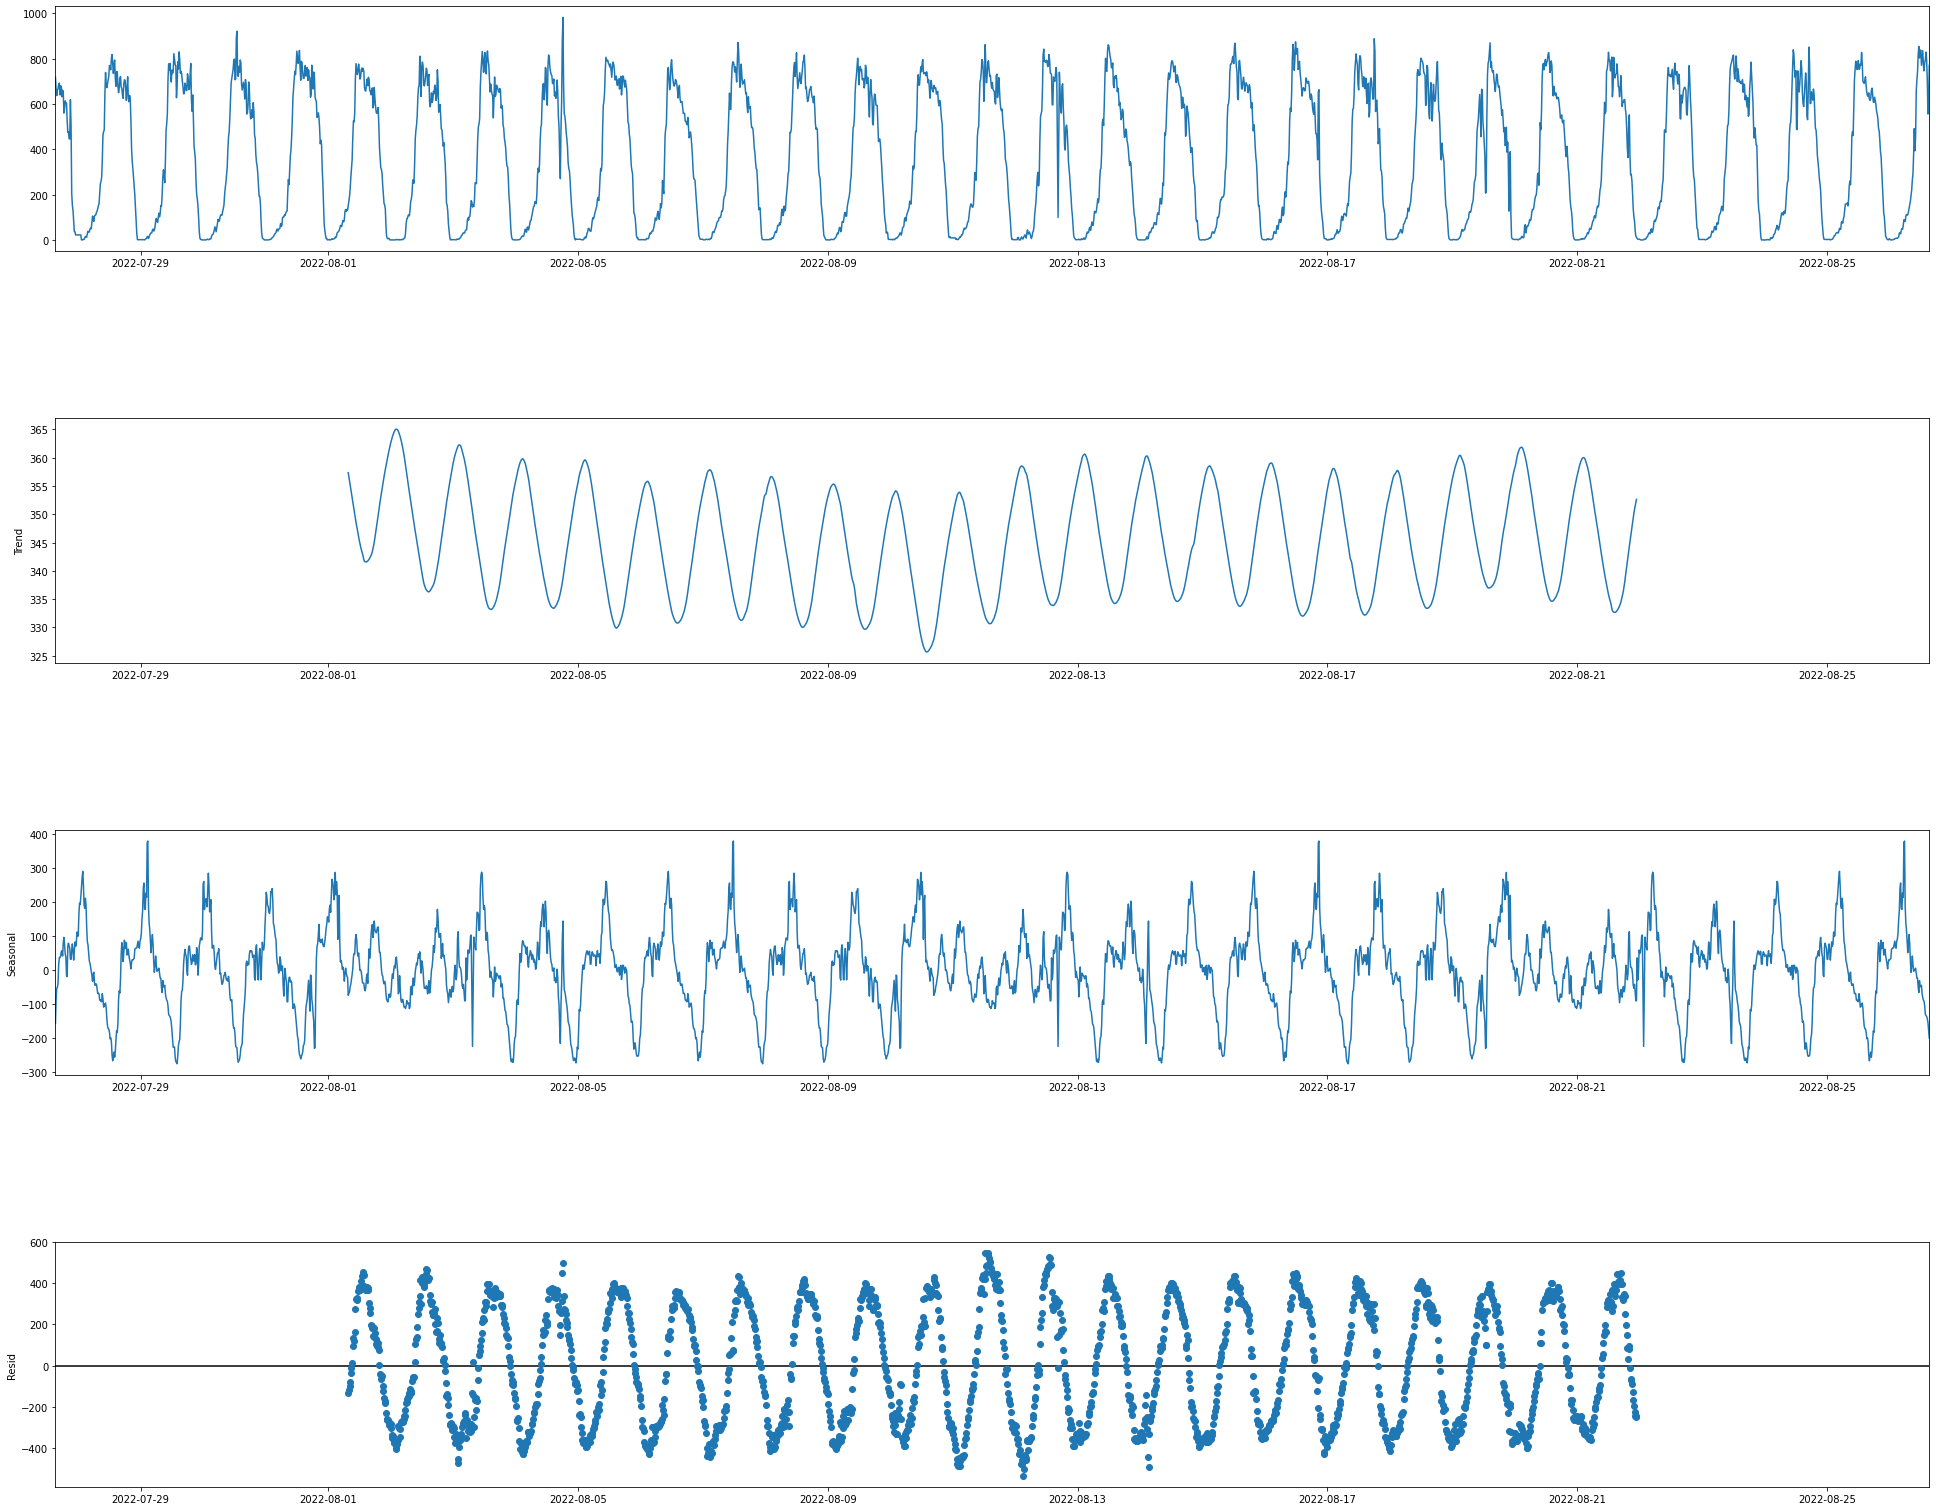

In [138]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataframe,period = 60*15)

fig = result.plot()
fig.set_size_inches(32,24)
plt.show()

* residual function looks like sine but not perfect, maybe these values are anomaly

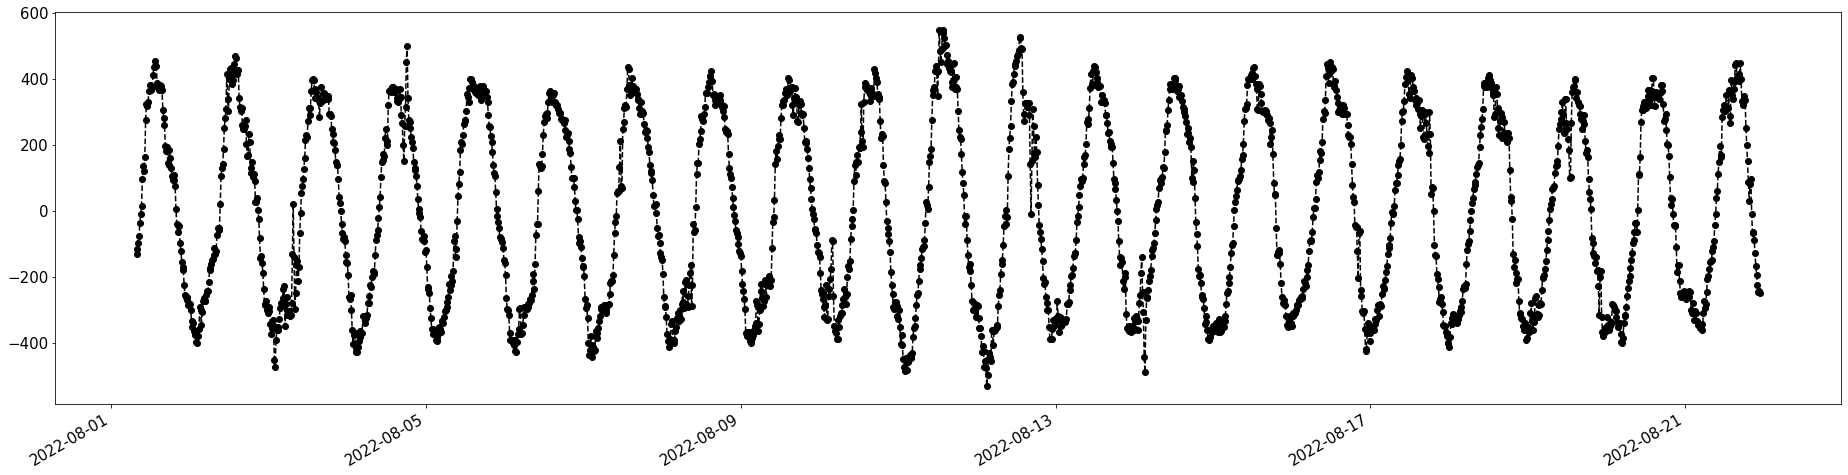

In [246]:
plt.rc('figure',figsize=(32,8))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x_data = result.resid.index
y_data = result.resid.values
ax.plot_date(x_data, y_data, color='black',linestyle='--')
fig.autofmt_xdate()
plt.show()

* non-zero values percentage in residual:  

In [248]:
np.count_nonzero(~np.isnan(y_data))/len(y_data)

#remove all tailing nulls:
y_data = pd.Series(y_data)
last_valid = y_data[y_data.notnull()].index[-1]
y_curr = y_data.iloc[0:last_valid]

#remove all leading nulls:
first_valid = y_curr[y_curr.notnull()].index[0]
y_curr = y_curr.iloc[first_valid:]
y_curr.head()
print(y_curr.index[0])
print(y_curr)
print(y_curr.index[-1])
resid_df = pd.DataFrame()
resid_df.index = x_data[y_curr.index[0]:y_curr.index[-1] + 1]
resid_df['data'] = y_curr.values

450
450    -132.680074
451    -116.938222
452     -98.220630
453     -77.499889
454     -37.119704
           ...    
2425   -166.631185
2426   -194.104704
2427   -225.499889
2428   -245.792667
2429   -243.717667
Length: 1980, dtype: float64
2429


In [250]:
resid_df['data']

Time
2022-08-01 07:45:00   -132.680074
2022-08-01 08:00:00   -116.938222
2022-08-01 08:15:00    -98.220630
2022-08-01 08:30:00    -77.499889
2022-08-01 08:45:00    -37.119704
                          ...    
2022-08-21 21:30:00   -166.631185
2022-08-21 21:45:00   -194.104704
2022-08-21 22:00:00   -225.499889
2022-08-21 22:15:00   -245.792667
2022-08-21 22:30:00   -243.717667
Name: data, Length: 1980, dtype: float64

In [251]:
np.count_nonzero(~np.isnan(resid_df['data']))/len(resid_df['data'])

1.0

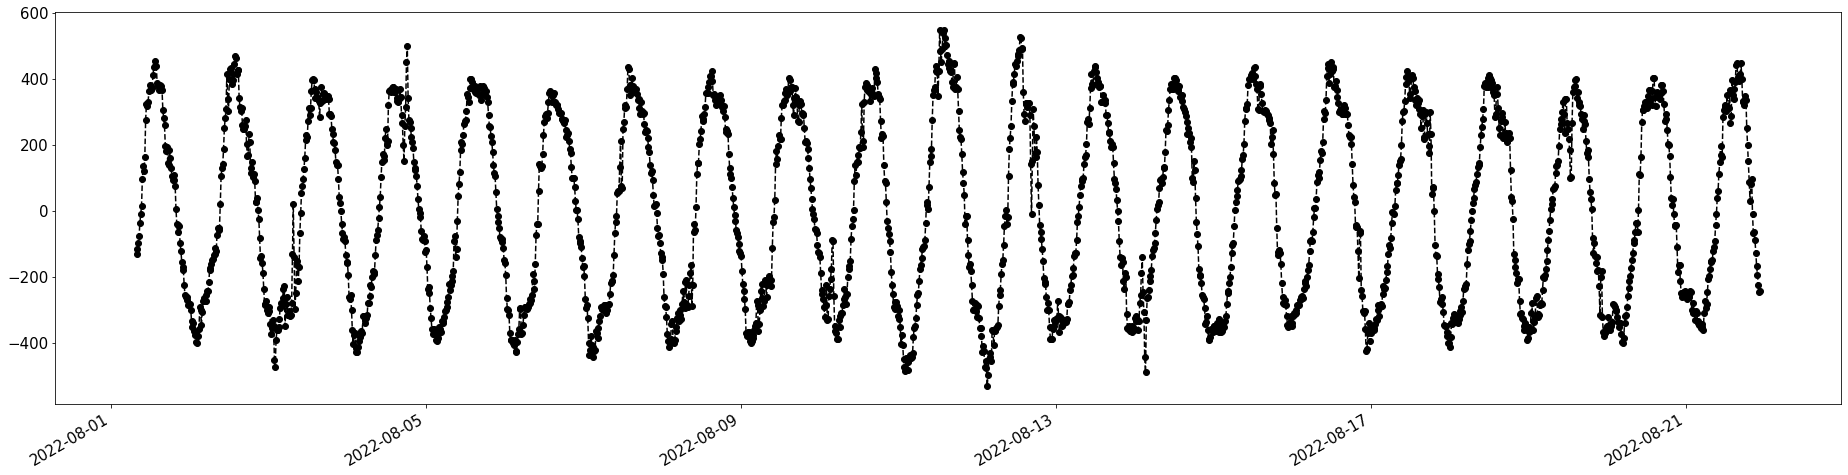

In [252]:
plt.rc('figure',figsize=(32,8))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x_data = resid_df.index
y_data = resid_df['data']
ax.plot_date(x_data, y_data, color='black',linestyle='--')
fig.autofmt_xdate()
plt.show()

### 1 model: Least squares fitting

In [255]:
from scipy import optimize
#guessed func

def guessed_func(x, dist, amp, omega, phi):
    return dist + amp * np.cos(omega * x + phi)

params, params_covariance = optimize.curve_fit(guessed_func, range(0,len(y_data)), y_data, p0=[1, 1, 2, 1])

In [257]:
from IPython.display import display, Math
print('Fitted parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*params)))

Fitted parameters:


<IPython.core.display.Math object>

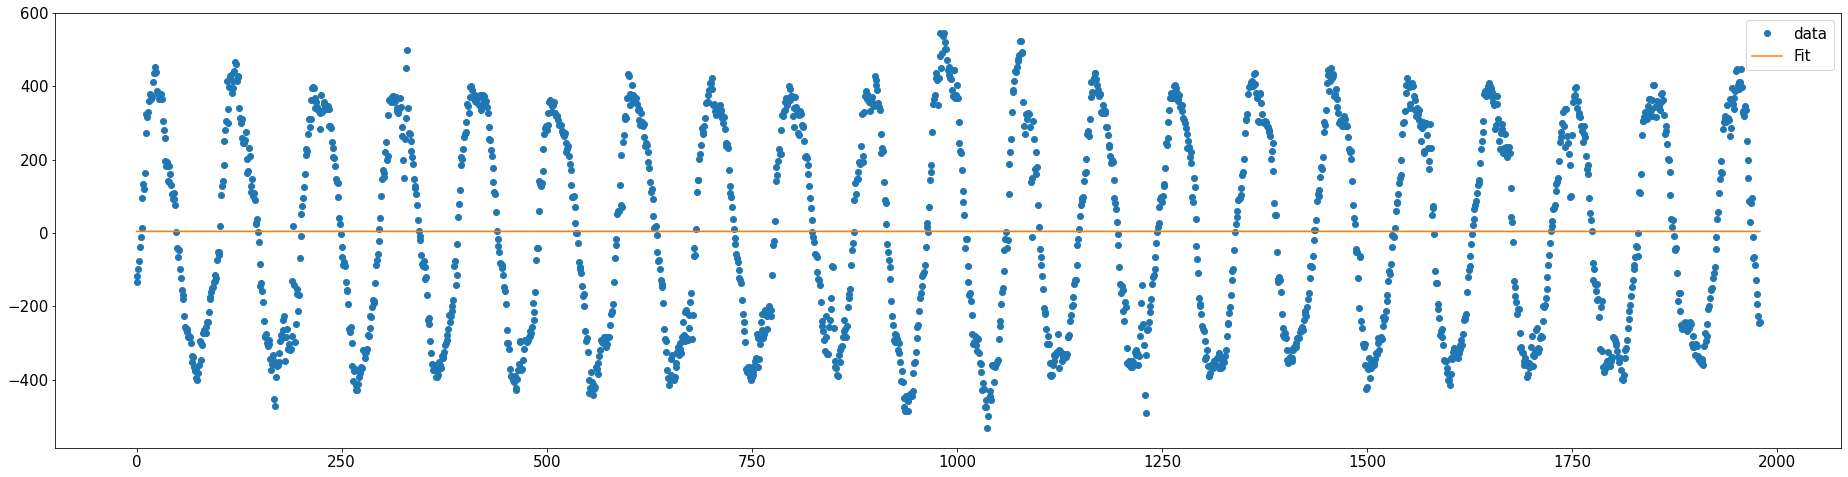

In [261]:
x_fit = range(0,len(y_data))   #range of x values used for the fit function
plt.plot(x_fit, y_data, 'o', label='orginal data')
plt.plot(x_fit, guessed_func(x_fit, *params), '-', label='Fittted data')
plt.legend()
plt.show()

### Train test split

In [140]:
test_size = int(0.8*len(dataframe))
df_train = dataframe[:-test_size]
df_test = dataframe[-test_size:]

2304


###  